# Identifying patients with psychosis using edge time series analysis of resting-state functional connectivity imaging

This analysis used resting-state functional magnetic resonance imaging (fMRI) from the COBRE dataset (The Center for Biomedical Research Excellence (COBRE)). This dataset can be accessed via http://fcon_1000.projects.nitrc.org/indi/retro/cobre.html. 
Following pre-processing, the data for 81 controls and 67 subjects with a diagnosis of schizophrenia was included.

Edge time series analysis measures the magnitude of cofluctuation between pairs of nodes by calculating the element wise product of the time series from each pair of nodes. This allows for measurement of cofluctuation at a frame-by-frame resolution without requiring user-specified parameters or appling additional modeling to the data. See papers below for more information regarding this methadology:

Sporns, O. et al. (2021) ‘Dynamic expression of brain functional systems disclosed by fine-scale analysis of edge time series’. doi: 10.1162/netn_a_00182.

Esfahlani, F. Z. et al. (2020) ‘High-amplitude cofluctuations in cortical activity drive functional connectivity’, Proceedings of the National Academy of Sciences of the United States of America, 117(45), pp. 28393–28401. doi: 10.1073/pnas.2005531117.


For this notebook the resting-state fMRI data has already been pre-processed and analysed using matlab. 

To reduce the dimentionality of the data, the Root Sum Squares (RSS) was used as an aggregate measure of global cofluctuation for each participant. The predictor (X) was therefore the RSS (an array of RSS values for wach frame in the imaging for each participant. The outcome is status as either control (0) or patient with a diagnosis of psychosis (1).

This dataset is limited in that it is very small for the application of Machine Learning algorithms but the following methods were compared more as a learning exercise.

Sections: 
1) Data processing and visualisation

2) Initial predictions and models
- Logistic Regression
- Support vector machines (SVMs)
- Decision tree classifier

3) Ensemble Methods
- Random Forest Classifier
- XGBoost
- AdaBoost
- Combining techniques

4) Summary

5) Bonus additional visualisation


In [426]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Data processing and visualisation

The data was imported from csv files. 
X is a numpy array of the input features with n rows were each row is a sequence of RSS amplitudes corresponding to the time frames kept in order. 
y is a label vector of 0s (controls) and 1s (patients) where each values is the label for the corresponding row in X. 

In [579]:

X = np.genfromtxt('C:/Users/abiga/Documents/ACF/Research/Edge_time_series/data/data/rss_all.csv', delimiter= ',',encoding="utf-8-sig")
X

array([[117.5325076 , 226.2376663 , 248.0142608 , ..., 233.2359336 ,
        221.5753627 , 359.9631692 ],
       [106.2423876 , 148.3374872 , 176.6138521 , ..., 154.3794195 ,
        173.6307566 , 212.1443933 ],
       [205.7293416 , 273.5543833 , 205.7046429 , ..., 201.3377617 ,
        184.6462567 , 156.6660083 ],
       ...,
       [ 92.67487885, 159.5821325 , 186.6606448 , ..., 122.9250376 ,
        473.1492189 , 158.440663  ],
       [118.4342225 , 204.0743819 , 324.2800536 , ..., 203.4989402 ,
        159.1524111 , 160.7431241 ],
       [181.9207065 , 216.7577915 , 236.8398466 , ..., 168.2937816 ,
        235.5345917 , 210.3622731 ]])

Plot of RSS amplitudes for all subjects and all frames.

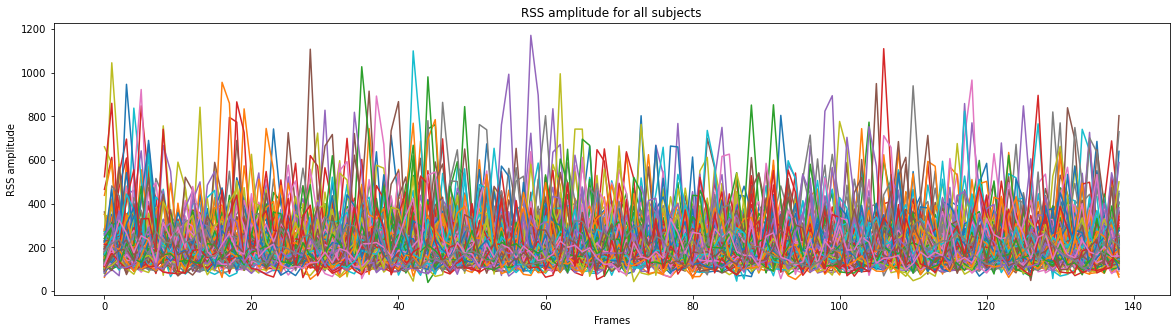

In [580]:
rss= plt.figure()
rss.set_figwidth(20)
rss.set_figheight(5)

plt.plot(X.T)
plt.title("RSS amplitude for all subjects") 
plt.xlabel("Frames") 
plt.ylabel("RSS amplitude") 

plt.show()

In [581]:
y = np.genfromtxt('C:/Users/abiga/Documents/ACF/Research/Edge_time_series/data/data/labels.csv', delimiter= ',',encoding="utf-8-sig")
y

array([0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1.])

Check the shape of the imported data. 

In [435]:
print(X.shape, y.shape)

(148, 139) (148,)


Split RSS values to display patient and controls RSS seperately.

In [436]:
# using enumerate() to find indices for y= 0
controls_indices = [i for i, value in enumerate(y) if value == 0]
patients_indices= [i for i, value in enumerate(y) if value == 1]
           
# printing resultant list of indices
print ("Controls indices : " + str(controls_indices))
print ("Patients indices : " + str(patients_indices))

# printing the corresponding row of X (RSS amplitudes)
controls= X[controls_indices, :]
patients= X[patients_indices, :]

print (controls)
print (patients)

Controls indices : [0, 8, 9, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 27, 30, 31, 36, 40, 44, 49, 50, 51, 52, 53, 54, 55, 56, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 76, 77, 79, 81, 82, 83, 84, 87, 88, 89, 90, 91, 93, 95, 97, 99, 100, 101, 104, 107, 109, 116, 119, 120, 122, 124, 125, 128, 131, 132, 133, 134, 135, 138, 139, 140, 141, 144]
Patients indices : [1, 2, 3, 4, 5, 6, 7, 10, 11, 13, 24, 25, 26, 28, 29, 32, 33, 34, 35, 37, 38, 39, 41, 42, 43, 45, 46, 47, 48, 57, 58, 74, 75, 78, 80, 85, 86, 92, 94, 96, 98, 102, 103, 105, 106, 108, 110, 111, 112, 113, 114, 115, 117, 118, 121, 123, 126, 127, 129, 130, 136, 137, 142, 143, 145, 146, 147]
[[117.5325076  226.2376663  248.0142608  ... 233.2359336  221.5753627
  359.9631692 ]
 [352.2156583  323.6284396  218.4730306  ... 126.8854939  319.8640903
  104.8589992 ]
 [166.5860943  246.977191   109.0957762  ... 113.5802598  255.939379
  178.245682  ]
 ...
 [225.1241108  465.6143201  137.9856869  ... 245.7081129  184.328018

Plot RSS amplitudes for patients and controls.

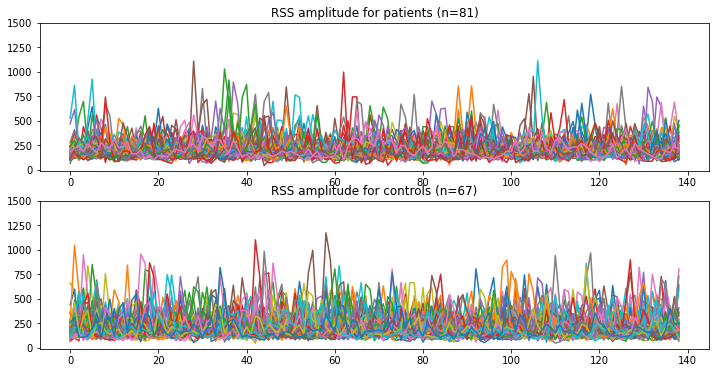

In [437]:
fig, (ax1, ax2)= plt.subplots(nrows= 2, ncols= 1, figsize= (12, 6))

ax1.plot(patients.T)
ax2.plot(controls.T)

# Set same axis scale for comparison 
ax1.set_title("RSS amplitude for patients (n=81)") 
ax1.set_yticks([0,250,500,750,1000, 1250, 1500])
ax2.set_title("RSS amplitude for controls (n=67)") 
ax2.set_yticks([0,250,500,750,1000, 1250, 1500])


plt.show()


# 2) Predictions and models

## Logistic regression

The first model tried was logistic regression. Cross validation was used due to the small sample size. Scores evaluated using precision and recall as the dataset is imbalanced. 

In [438]:
from sklearn.linear_model import LogisticRegression

# Define the model (use default parameters)
clf = LogisticRegression(penalty='l2', C=1)

# Test the model using cross-validation
# use 5 fold cross validation over your data 1/5th of your data is used for scoring and you roll over your data 5 times
scores_lr = cross_validate(clf, X, y, cv=5, scoring = ['precision', 'recall'])

# Show the scores
print(f"Logistic regression mean precision: {scores_lr['test_precision'].mean()}")
print(f"Logistic regression mean recall: {scores_lr['test_recall'].mean()}")

Logistic regression mean precision: 0.5693455564043799
Logistic regression mean recall: 0.5978021978021978


C:\Users\abiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\abiga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Tried using logistic regression with scaling to see if this solved the error of reaching the limit of iterations and improved the performance.

In [439]:
# Scaling applied to X
X_scaled = ((X.T-X.min(1))/((X.T-X.min(1))).max(0)).T

# Test the model using cross-validation
scores_lr_scaled = cross_validate(clf, X_scaled, y, cv=5, scoring = ['precision', 'recall'])

# Show the scores
print(f"Logistic regression with scaling mean precision: {scores_lr_scaled['test_precision'].mean()}")
print(f"Logistic regression with scaling mean recall: {scores_lr_scaled['test_recall'].mean()}")

Logistic regression with scaling mean precision: 0.6159951159951159
Logistic regression with scaling mean recall: 0.554945054945055


Also tried altering other parameters including solver (the algorithm to use in the optimization problem). Liblinear is thought to perform well for smaller datasets so this was tried.

In [440]:
# Define the model (use liblinear)
clf = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')

# Test the model using cross-validation
scores_lr_lib = cross_validate(clf, X_scaled, y, cv=5, scoring = ['precision', 'recall'])

# Show the scores
print(f"Logistic regression mean precision: {scores_lr_lib['test_precision'].mean()}")
print(f"Logistic regression mean recall: {scores_lr_lib['test_recall'].mean()}")

Logistic regression mean precision: 0.5778221778221778
Logistic regression mean recall: 0.554945054945055


Tried altering other parameters including C (for which smaller values specify stronger regularization) and penalty (l1, L2 and none). See below example but many other combintions of parameters where tried.

In [441]:
# Define the model (use liblinear)
clf = LogisticRegression(penalty='l1', C=0.5, solver= 'liblinear')

# Test the model using cross-validation
scores_lr_lib = cross_validate(clf, X_scaled, y, cv=5, scoring = ['precision', 'recall'])

# Show the scores
print(f"Logistic regression mean precision: {scores_lr_lib['test_precision'].mean()}")
print(f"Logistic regression mean recall: {scores_lr_lib['test_recall'].mean()}")

Logistic regression mean precision: 0.562857142857143
Logistic regression mean recall: 0.221978021978022


From adjusting the parameters (penalty, C and solver) the best performing model (although still fairly poor) found was with penalty=l2, solver= ‘lbfgs’, scaling and C=1.0

In [442]:
# Define the model
clf = LogisticRegression(penalty='l2', C=1.0, solver= 'lbfgs')

# Test the model using cross-validation
scores_lr_lib = cross_validate(clf, X_scaled, y, cv=5, scoring = ['precision', 'recall'])

# Show the scores
print(f"Logistic regression mean precision: {scores_lr_lib['test_precision'].mean()}")
print(f"Logistic regression mean recall: {scores_lr_lib['test_recall'].mean()}")

Logistic regression mean precision: 0.6159951159951159
Logistic regression mean recall: 0.554945054945055


## Support vector machines (SVMs)

Support vector machines (SVMs) can be useful when the the dataset is small or where number of dimensions is greater than the number of samples. 

Support Vector Classification (SVC) is one method for doing this. 

Class weights "balanced” mode was used as the two groups are not equal in size. This uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data.

In [443]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

# define model with min max scaler and SVC classifier 
clf = make_pipeline(MinMaxScaler(), SVC(C=1.0, class_weight='balanced'))

# Test the model using cross-validation
scores_svc = cross_validate(clf, X, y, cv=5, scoring=['precision', 'recall'])

# Show the scores
print(f"SVC mean precision: {scores_svc['test_precision'].mean()}")
print(f"SVC mean recall: {scores_lr['test_recall'].mean()}")

SVC mean precision: 0.5790909090909091
SVC mean recall: 0.5978021978021978


Tried without scaling for comparison and also tried altering values of C. 

In [444]:
# define model with min max scaler and your SVC classifier 
clf = make_pipeline(SVC(C=0.5, class_weight='balanced'))

# Test the model using cross-validation
scores_svc = cross_validate(clf, X, y, cv=5, scoring=['precision', 'recall'])

# Show the scores
print(f"SVC mean precision: {scores_svc['test_precision'].mean()}")
print(f"SVC mean recall: {scores_svc['test_recall'].mean()}")

SVC mean precision: 0.5814102564102563
SVC mean recall: 0.5857142857142856


Best performance found was without scaling and with C= 0.9

In [445]:
# define model with min max scaler and your SVC classifier 
clf = make_pipeline(SVC(C=0.9, class_weight='balanced'))

# Test the model using cross-validation
scores_svc = cross_validate(clf, X, y, cv=5, scoring=['precision', 'recall'])

# Show the scores
print(f"SVC mean precision: {scores_svc['test_precision'].mean()}")
print(f"SVC mean recall: {scores_svc['test_recall'].mean()}")

SVC mean precision: 0.6187146187146186
SVC mean recall: 0.6


## Decision tree classifier

Tried using decision trees to see if that could improve performance.

In [630]:
from sklearn.tree import DecisionTreeClassifier

# Define the model
clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2,
    random_state=42)

# Fit the model
clf = clf.fit(X_scaled, y)

# Test the model using cross-validation
scores_dtc= cross_validate(clf, X_scaled, y, cv=5, scoring= ['precision', 'recall'])

# Show the scores
print(f"Decision tree mean precision: {scores_dtc['test_precision'].mean()}")
print(f"Decision tree mean recall: {scores_dtc['test_recall'].mean()}")

Decision tree mean precision: 0.4713675213675213
Decision tree mean recall: 0.49230769230769234


Decision trees can be visualised which makes them more easy to interpret than other complex models. 
Display the structure of a single decision tree trained on RSS values.

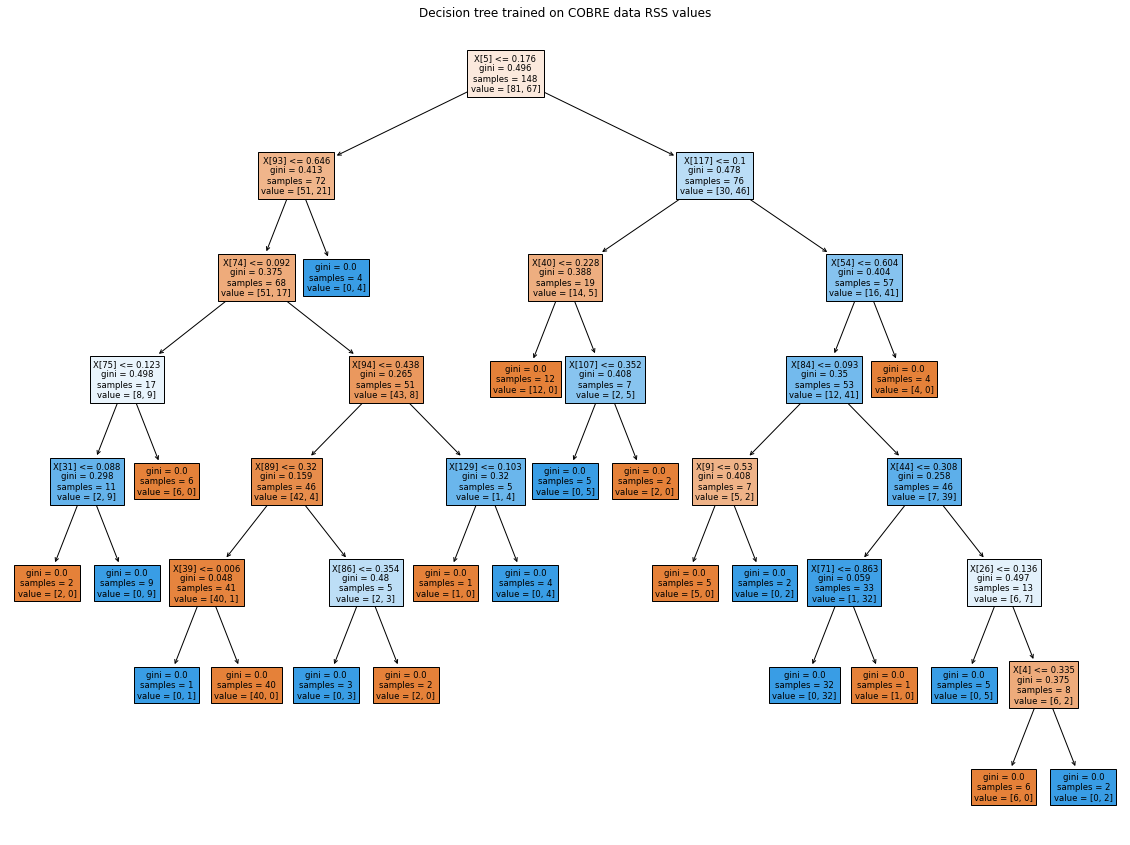

In [447]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,15))
tree_plot= plot_tree(clf, filled=True)
plt.title("Decision tree trained on COBRE data RSS values")
plt.show()

# 3) Ensemble techniques

We decided to try ensemble apporaches to see if they could provide improved performance compared to the more simple models.

## Random Forest Classifier

A random forest is a an ensemble technique that fits mutliple decision tree classifiers (see above) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [448]:
from sklearn.ensemble import RandomForestClassifier

In [624]:
from sklearn.ensemble import RandomForestClassifier

# Define the model
clf = RandomForestClassifier(n_estimators=40)

# Test the model using cross-validation
scores_rf = cross_validate(clf, X, y, cv=5, scoring=['precision', 'recall'])

# Show the scores
print(f"Random forest mean precision: {scores_rf['test_precision'].mean()}")
print(f"Random forest mean recall: {scores_rf['test_recall'].mean()}")

Random forest mean precision: 0.6138888888888888
Random forest mean recall: 0.4197802197802198


##  XGBoost

Boosting is a sequential technique which works on the principle of an ensemble. It combines a set of weak learners and aims to deliver improved prediction accuracy.

In [459]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [460]:
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split

Defined the model and tested using cross validation. The model performed more poorly with the use of scaling. 

In [501]:
# Define the model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric= 'error', use_label_encoder=False)

# Test the model using cross-validation
scores_xgb = cross_validate(xgb_model, X, y, cv=5, scoring=['precision', 'recall'])

# Show the scores
print(f"XGB with kfold cross-validation mean precision: {scores_xgb['test_precision'].mean()}")
print(f"XGB with kfold cross-validation mean recall: {scores_xgb['test_recall'].mean()}")

XGB with kfold cross-validation mean precision: 0.5999650349650348
XGB with kfold cross-validation mean recall: 0.4923076923076922


Tried using XGBoost with cross-validation using kfold:

In [499]:
# Define the model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric= 'error', use_label_encoder=False)

# Test the model using k-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=7)

scores_xgb = cross_validate(xgb_model, X, y, cv=kfold, scoring=['precision', 'recall'])

# Show the scores
print(f"XGB with kfold cross-validation mean precision: {scores_xgb['test_precision'].mean()}")
print(f"XGB with kfold cross-validation mean recall: {scores_xgb['test_recall'].mean()}")

XGB with kfold cross-validation mean precision: 0.48690476190476184
XGB with kfold cross-validation mean recall: 0.445


Used hyperparameter searching to identify the best parameters to be used with XGBoost:

In [462]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [463]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
xgb_model = xgb.XGBRegressor()

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X, y)
report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Model with rank: 1
Mean validation score: -0.156 (std: 0.312)
Parameters: {'colsample_bytree': 0.9519366578369711, 'gamma': 0.43349688000576175, 'learning_rate': 0.15239534860945342, 'max_depth': 2, 'n_estimators': 102, 'subsample': 0.6924299186352285}



Used the paramters with the best score in the model with k-fold cross validation:

In [494]:
# Define the model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric= 'error', use_label_encoder=False, colsample_bytree= 0.9519366578369711, gamma= 0.43349688000576175, learning_rate= 0.15239534860945342, max_depth= 2, n_estimators= 102, subsample= 0.6924299186352285)

# Test the model using k-fold cross-validation
scores_xgb = cross_validate(xgb_model, X, y, cv=kfold, scoring=['precision', 'recall'])

# Show the scores
print(f"XGB with kfold cross-validation mean precision: {scores_xgb['test_precision'].mean()}")
print(f"XGB with kfold cross-validation mean recall: {scores_xgb['test_recall'].mean()}")

XGB with kfold cross-validation mean precision: 0.5571428571428572
XGB with kfold cross-validation mean recall: 0.4991666666666667


Performance of the model was improved by using hyperparameter searching (although again performance remains poor and is not as good as SVC).

## AdaBoost

AdaBoost also called Adaptive Boosting is a technique in Machine Learning used as an Ensemble Method. 

In [466]:
from sklearn.ensemble import AdaBoostClassifier

# Define the model
clf = AdaBoostClassifier(n_estimators=1000)

# Test the model using cross-validation
scores_ada = cross_validate(clf, X_scaled, y, cv=3, scoring= ['precision', 'recall'])

# Show the scores
print(f"AdaBoost mean precision: {scores_ada['test_precision'].mean()}")
print(f"AdaBoost forest mean recall: {scores_ada['test_recall'].mean()}")

AdaBoost mean precision: 0.550383631713555
AdaBoost forest mean recall: 0.5790513833992095


## Combining methods

In [616]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

# Define the models
clf1 = LogisticRegression(penalty='l2', C=1.0, solver= 'lbfgs')
clf2 = SVC(C=0.9, class_weight='balanced', probability=True)
clf3= RandomForestClassifier(n_estimators=40)
eclf = VotingClassifier(
    estimators=[("lr", clf1), ("svc", clf2), ("rf", clf3)],
    voting="soft",
    weights=[2,1,1],
)

# Fit the combined model
eclf.fit(X_scaled, y)
eclf.predict(X_scaled)

# Test the model using cross-validation
scores1 = cross_validate(clf1, X_scaled, y, cv=5, scoring= ['precision', 'recall'])
scores2 = cross_validate(clf2, X_scaled, y, cv=5, scoring= ['precision', 'recall'])
scores3 = cross_validate(clf3, X_scaled, y, cv=5, scoring= ['precision', 'recall'])
scores_combine = cross_validate(eclf, X_scaled, y, cv=5, scoring= ['precision', 'recall'])

In [617]:
print(f"Logistic Regression precision score is {scores1['test_precision'].mean()}")
print(f"SVC precision score is {scores2['test_precision'].mean()}")
print(f"Random Forest Classifier precision score is {scores3['test_precision'].mean()}")
print(f"Combined precision score is {scores_combine['test_precision'].mean()}")

Logistic Regression precision score is 0.6159951159951159
SVC precision score is 0.5553113553113552
Random Forest Classifier precision score is 0.641904761904762
Combined precision score is 0.561025641025641


In [618]:
print(f"Logistic Regression recall score is {scores1['test_recall'].mean()}")
print(f"SVC precision recall is {scores2['test_recall'].mean()}")
print(f"Random Forest Classifier recall score is {scores3['test_recall'].mean()}")
print(f"Combined recall score is {scores3['test_recall'].mean()}")

Logistic Regression recall score is 0.554945054945055
SVC precision recall is 0.4802197802197803
Random Forest Classifier recall score is 0.389010989010989
Combined recall score is 0.389010989010989


# 4) Summary

Overall the model scores (precision and recall) are relatively low. The best performing models where SVC, logistic regression and random forest classifier. Combining these approaches at various weights did not outperform the best models on their own. 

Precision-recall curve for SVC model:

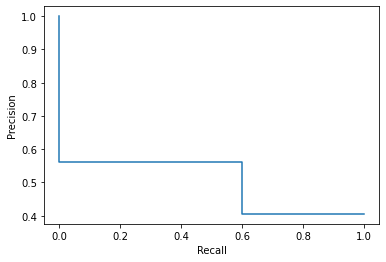

In [605]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import (precision_recall_curve,
                             PrecisionRecallDisplay)
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

# Define the model
clf = SVC(C=0.9, class_weight='balanced', probability=True)

# Fit the model
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

# Plot the precision recall curve
precision, recall, _ = precision_recall_curve(y_test, predictions)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)

disp.plot()

plt.show()


Precision-recall curve for combining SVC, logistic regression and random forest models:

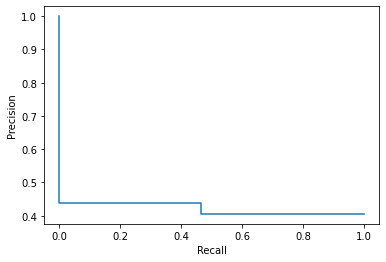

In [627]:
# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    random_state=0)

# Define the models
clf1 = LogisticRegression(penalty='l2', C=1.0, solver= 'lbfgs')
clf2 = SVC(C=0.9, class_weight='balanced', probability=True)
clf3= RandomForestClassifier(n_estimators=40)
eclf = VotingClassifier(
    estimators=[("lr", clf1), ("svc", clf2), ("rf", clf3)],
    voting="soft",
    weights=[2,1,1],
)

# Fit the model
eclf.fit(X_train, y_train)
predictions = eclf.predict(X_test)

# Plot the precision recall curve
precision, recall, _ = precision_recall_curve(y_test, predictions)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

plt.show()


# 5) Bonus additional visualisation

This section explores how edge-centric measures of connectivity relate to standard measures of static connectivity. 

Below the mean RSS values and mean static FC value (calculated using matlab) are compared and plotted for patients and controls. 

In [474]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Import measures of mean RSS and mean FC values for each participants. Status 0 = control, 1 = patient. 

In [475]:
df= pd.read_csv('C:/Users/abiga/Documents/ACF/Research/Edge_time_series/Output_cobre/mean_rss_fc.csv')
df

,Status,Mean RSS,Mean FC
0,0,557.581664,0.288912
1,1,484.044921,0.157316
2,1,521.507490,0.093813
3,1,471.500857,0.240028
4,1,555.581422,0.180348
...,...,...,...
143,1,746.040787,0.567138
144,0,594.784562,0.400800
145,1,518.620532,0.310584
146,1,412.743778,0.204260


Scatter plots of mean RS and mean static FC split for patients and controls. 

Text(0.5, 1.0, 'Mean RSS and static FC for patients and controls')

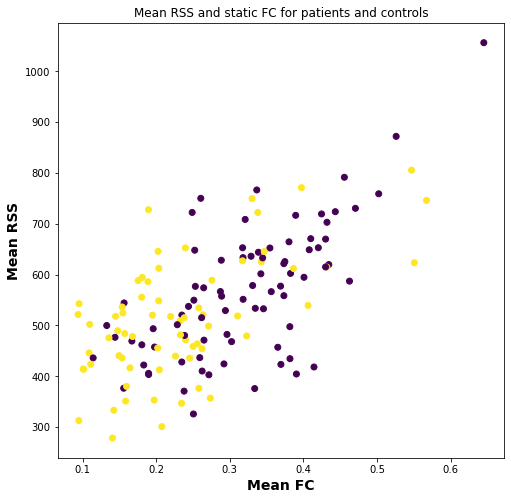

In [476]:
plt.figure(figsize=(8,8))
plt.scatter(x=df['Mean FC'],
            y=df['Mean RSS'],
            c=df['Status'])
plt.xlabel("Mean FC",
            fontweight ='bold',
            size=14)
plt.ylabel("Mean RSS",
           fontweight ='bold',
           size=14)
plt.savefig("Mean_RSS_FC.png",
                    format='png',dpi=150)
plt.title('Mean RSS and static FC for patients and controls')



Text(0.5, 1.0, 'Relationship between mean RSS and static FC for patients and controls')

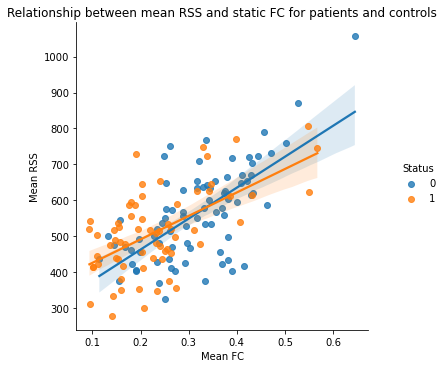

In [477]:
sns.lmplot(x='Mean FC', 
           y= 'Mean RSS', 
           hue= 'Status', 
           data=df)

ax = plt.gca()
ax.set_title("Relationship between mean RSS and static FC for patients and controls")